In [16]:
import numpy as np
import json
import bz2
import pandas as pd 
import os
import matplotlib.pyplot as plt
# import pandas as pd
from pymatgen.core import Structure
pd.options.display.max_colwidth = 100

{'runs_2/spg01/Ag/AgI/xxx_02a-00_1-2-Ag1a.I1a': [{'structure': {'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[4.79402036, 0.0, 0.0], [-2.39701018, 4.14033947, 0.0], [0.0, 0.0, 15.01098665]], 'pbc': [True, True, True], 'a': 4.79402036, 'b': 4.784147649254098, 'c': 15.01098665, 'alpha': 90.0, 'beta': 90.0, 'gamma': 120.06828784288422, 'volume': 297.9511483538181}, 'sites': [{'species': [{'element': 'I', 'occu': 1}], 'abc': [0.73438796, 0.77036907, 0.49963405], 'xyz': [1.6740883292317328, 3.189589466988193, 7.500000054435432], 'label': 'I', 'properties': {}}, {'species': [{'element': 'Ag', 'occu': 1}], 'abc': [0.40045405, 0.10251431, 0.50036595], 'xyz': [1.6740570242787822, 0.42444404393281565, 7.5109865955645665], 'label': 'Ag', 'properties': {}}]}, 'energy': -4.73892286, 'forces': [[0.0, -0.00265801, 0.00157733], [0.0, 0.00265801, -0.00157733]], 'stress': [[-0.03762109, 0.0, 0.0], [0.0, 0.0247052, -0.00097993], [0.0, -0.00097977, -0.43

,run,energy,force_1,force_2,stress_xx,stress_xy,stress_xz,stress_yx,stress_yy,stress_yz,stress_zx,stress_zy,stress_zz,structure
0,runs_2/spg01/Ag/AgI/xxx_02a-00_1-2-Ag1a.I1a_0,-4.738923,"[0.0, -0.00265801, 0.00157733]","[0.0, 0.00265801, -0.00157733]",-0.037621,0.000000,0.000000,0.000000,0.024705,-0.000980,0.000000,-0.000980,-0.433920,"[[1.67408833 3.18958947 7.50000005] I, [1.67405702 0.42444404 7.5109866 ] Ag]"
1,runs_2/spg01/Ag/AgI/xxx_02a-00_1-2-Ag1a.I1a_1,-4.738923,"[-0.0, -0.00265802, 0.0015776]","[0.0, 0.00265802, -0.0015776]",-0.037627,0.000000,0.000000,0.000000,0.024699,-0.000980,0.000000,-0.000980,-0.433889,"[[1.67408833 3.18958947 7.50000005] I, [1.67405702 0.42444404 7.5109866 ] Ag]"
2,runs_2/spg01/Ag/AgI/xxx_02a-00_1-2-Ag1a.I1a_2,-4.738923,"[-0.0, -0.00265752, 0.00157476]","[0.0, 0.00265752, -0.00157476]",-0.038770,0.000000,0.000000,0.000000,0.023558,-0.000980,0.000000,-0.000980,-0.435258,"[[1.67408833 3.18958947 7.50000005] I, [1.67405702 0.42444404 7.5109866 ] Ag]"
3,runs_2/spg01/Al/AlAs/xxx_02a-00_1-2-Al1a.As1a_0,-8.360449,"[0.0, 0.0, 0.00322263]","[-0.0, -0.0, -0.00322263]",-0.033229,0.000000,0.000000,-0.000000,-0.033229,0.000000,0.000000,0.000000,-0.130624,"[[1.17735831 1.75092979 7.50000001] As, [-0.85332578 2.92343297 7.94709612] Al]"
4,runs_2/spg01/Al/AlAs/xxx_02a-00_1-2-Al1a.As1a_1,-8.360449,"[0.0, 0.0, 0.00322412]","[-0.0, -0.0, -0.00322412]",-0.033231,0.000000,0.000000,0.000000,-0.033231,0.000000,0.000000,0.000000,-0.130558,"[[1.17735831 1.75092979 7.50000001] As, [-0.85332578 2.92343297 7.94709612] Al]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,runs_2/spg01/Zn/ZnTe/xxx_02a-00_1-2-Zn1a.Te1a_34,-3.796233,"[-0.00188398, 0.00278006, 0.00056423]","[0.00188398, -0.00278006, -0.00056423]",0.103851,0.009075,0.054432,0.009075,0.112209,-0.087854,0.054432,-0.087854,-0.518869,"[[0.8980854 1.68182098 7.4630447 ] Zn, [ 0.88221069 2.35571774 10.29932582] Te]"
2097,runs_2/spg01/Zn/ZnTe/xxx_02a-00_1-2-Zn1a.Te1a_35,-3.796235,"[-0.00180024, 0.00208718, -0.00039073]","[0.00180024, -0.00208718, 0.00039073]",-0.045112,0.010570,0.053899,0.010570,-0.035576,-0.081091,0.053899,-0.081091,-0.444785,"[[0.89797226 1.68302349 7.46337331] Zn, [ 0.8823977 2.35645869 10.29899721] Te]"
2098,runs_2/spg01/Zn/ZnTe/xxx_02a-00_1-2-Zn1a.Te1a_36,-3.795468,"[-0.00171627, 0.00238097, 0.0001173]","[0.00171627, -0.00238097, -0.0001173]",-0.107865,0.026905,0.054468,0.026905,-0.031077,-0.079835,0.054468,-0.079835,-0.477126,"[[0.89797226 1.68302349 7.50000005] Zn, [ 0.8823977 2.35645869 10.33562383] Te]"
2099,runs_2/spg01/Zn/ZnTe/xxx_02a-00_1-2-Zn1a.Te1a_37,-3.795471,"[-0.00202979, 0.00269942, -0.00010727]","[0.00202979, -0.00269942, 0.00010727]",0.030212,0.024559,0.054012,0.024559,-0.003514,-0.076428,0.054011,-0.076428,-0.466792,"[[0.89776329 1.68306949 7.50000558] Zn, [ 0.8824027 2.35622273 10.3356183 ] Te]"


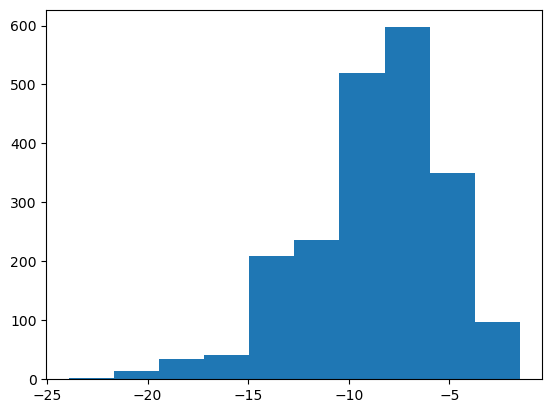

In [24]:
path = "geo_opt/2_spg01.json.bz2"
quantity = []
path_of_directory = 'geo_opt'
desired_quantity = 'energy'

df_data = pd.DataFrame(columns = ['structure', 'force_1', 'force_2', 'stress_xx', 'stress_xy', 'stress_xz', "stress_yx", "stress_yy", 'stress_yz', 'stress_zx', 'stress_zy', 'stress_zz'])
# display(df_data)

df_data = pd.DataFrame(columns=['run', 'energy', 'force_1', 'force_2', 'stress_xx', 'stress_xy', 'stress_xz', 'stress_yx', 'stress_yy', 'stress_yz', 'stress_zx', 'stress_zy', 'stress_zz'])
# file_data = json.load(bz2.open(path, "rb"))
# print(file_data)



#     ext = (".bz2")

def retrieve_forces(force_array):
    force_1, force_2 = force_array[0], force_array[1]
    return force_1, force_2



with bz2.BZ2File(path) as file:
    for line in file:
        line = line.decode().strip()
        if line in {"[", "]"}:
            continue
        if line.endswith(" "):
            line = line[:-1]
        entity =json.loads(line)
        print(entity)
        for runs in entity.keys():
            for item in entity[runs]:
                struc = Structure.from_dict(item['structure'])
                force_1, force_2 = retrieve_forces(item['forces'])
                stress = item['stress']
    
                energy = item['energy']

                data_run = pd.DataFrame({'run': runs,
                                         "structure": [struc],
                                         "energy": energy, 
                                         "force_1": [force_1], "force_2": [force_2], 
                                         'stress_xx': [stress[0][0]], 'stress_xy': [stress[0][1]], 'stress_xz':[stress[0][2]], 
                                         'stress_yx': [stress[1][0]], 'stress_yy': [stress[1][1]], 'stress_yz': [stress[1][2]], 
                                         'stress_zx': [stress[2][0]], 'stress_zy': [stress[2][1]], 'stress_zz': [stress[2][2]]})

                data_run = pd.DataFrame(data_run)
                df_data = pd.concat([df_data, data_run])
 

df_data.memory_usage()

df_data.reset_index(inplace=True, drop =True)
cum_series = df_data.groupby('run').cumcount()
cum_series = cum_series.astype(str)
df_data['run'] = df_data['run'] + "_" + cum_series

display(df_data)
        



def plotting_function(df, desired_quantity, savename):
        counts, bins = np.histogram(df[desired_quantity])
        plt.hist(bins[:-1], bins, weights = counts)
        
        plt.savefig("Figures/{}.pdf".format(savename))



plotting_function(df_data, "energy", "energy_dist")
#         # Get all the keys (runs)
#         # print(entity.keys())

#         for runs in entity.keys():
#             # The argument in entity specifies the run
#             for i in entity[runs]:                    
# #                 print(i.keys())
#                 value = i[desired_quantity]
#                 forces = i['forces']
#                 stress = i['stress']
#                 structure = i['structure']
#                 energy = i['energy']
#                 # print(forces)
#                 quantity.append(value)
                
# print(quantity)

In [ ]:
def return_quantity(directory, desired_quantity):
    # quantity can be structure, energy, forces, stress
#     path = "geo_opt/2_spg01.json.bz2"
    quantity = []
#     ext = (".bz2")
    print("Number of files in directory: {}".format(len(os.listdir(directory))))
    file_names = os.listdir(directory)
    # print(file_names)
#     for files in os.listdir(directory):
    for files in file_names:
        print("Current file selected: {}".format(files))
        with bz2.BZ2File("{}/{}".format(directory,files)) as file:
            for line in file:
                line = line.decode().strip()
                if line in {"[", "]"}:
                    continue
                if line.endswith(" "):
                    line = line[:-1]
                entity =json.loads(line)

                # Get all the keys (runs)
                # print(entity.keys())

                for runs in entity.keys():
                    # The argument in entity specifies the run
                    for i in entity[runs]:                    
#                         print(i.keys())
                        value = i[desired_quantity]
                        quantity.append(value)
#                         forces = i['forces']
#                         stress = i['stress']
#                         structure = i['structure']
#                         energy = i['energy']
#                         print(forces)
                
    with open("{}.txt".format(desired_quantity), 'w') as f:
        for s in quantity:
            f.write(str(s) + '\n')

    return quantity


energy = return_quantity('geo_opt','energy')

In [ ]:
with open("energy.txt", 'r') as f:
    energy = [line.rstrip('\n') for line in f]
    print(energy)

# print(energy)

In [ ]:
print(energy)

In [ ]:
counts, bins = np.histogram(energy)
plt.hist(bins[:-1], bins, weights = counts)